In [1]:
#build xgboost regressor model
import wandb
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RepeatedKFold, cross_val_score, RandomizedSearchCV
import numpy as np 
import shap 

In [3]:
# todo 
# import model to app.main.py
# test model in app.main.py
# use fastapi to deploy model to web
# test model in web
# create unit tests 
# containerize web app with docker
# deploy container to cloud using gcp cloud run 
# test web app in cloud
# learn toml shit 

In [ ]:
wandb.init(project="xgboost-regressor")

In [7]:
data = pd.read_csv('combined_data.csv')

In [6]:
data.head()

,Longitude (x),Latitude (y),Year,Month,Day,Max Temp (°C),Min Temp (°C),Mean Temp (°C),Heat Deg Days (°C),Cool Deg Days (°C)
0,-78.88,43.92,2019,1,1,4.9,-8.4,-1.8,19.8,0.0
1,-78.88,43.92,2019,1,2,-2.7,-12.2,-7.5,25.5,0.0
2,-78.88,43.92,2019,1,3,1.0,-4.8,-1.9,19.9,0.0
3,-78.88,43.92,2019,1,4,6.1,-3.4,1.4,16.6,0.0
4,-78.88,43.92,2019,1,5,2.6,-4.4,-0.9,18.9,0.0


In [112]:
X = data[["Year", "Month", "Day"]]

In [113]:
y = data["Mean Temp (°C)"]

In [114]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=80, shuffle=True)

In [115]:
y_train.count

<bound method Series.count of 1508    -4.8
105      1.9
1467    -2.7
668     -0.4
590     21.9
        ... 
407     -1.1
2051    20.7
522     19.0
1212     1.7
1199     9.8
Name: Mean Temp (°C), Length: 1534, dtype: float64>

In [116]:
y_test.count

<bound method Series.count of 370     -0.2
1323    22.1
1893     6.1
2119    11.4
147     11.4
        ... 
1840   -10.3
506     12.1
1333    20.2
1650    20.7
630     11.7
Name: Mean Temp (°C), Length: 658, dtype: float64>

In [386]:
#try this shit first 
xgr = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=1000, max_depth=2, eta=0.1, subsample=0.9, colsample_bytree=0.9)

In [387]:
xgr.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [530]:
pred = xgr.predict(x_test)

In [536]:
mae = np.abs(mean_absolute_error(y_test, pred))
print("MAE : % f " %(mae))

MAE :  3.044683 


In [390]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

In [532]:
#{'subsample': 1.0, 'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 8,
    'eta': 0.1,
    'learning_rate': 0.05,
    'subsample': 1.0,
    'colsample_bytree': 1.0
}

In [533]:
model = xgb.train(params, dtrain, num_boost_round=1000)

In [534]:
pred2 = model.predict(dtest)

In [543]:
mae2 = np.abs(mean_absolute_error(y_test, pred2))
print("MAE : % f " %(mae2))

MAE :  2.733898 


In [126]:
cfg = wandb.config 

In [72]:
cfg.update(params)

In [503]:
#cross validation 
cv = RepeatedKFold(n_splits=12, n_repeats=3, random_state=1)

In [504]:
#evaluate model? 
scores = cross_val_score(xgr, X, y, scoring="neg_mean_absolute_error", cv=cv, n_jobs=-2)

In [505]:
scores = np.absolute(scores)

In [506]:
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()))

Mean MAE: 3.066 (0.197)


In [508]:
# can find best parameters for model using parameter search
param_dist = {
    'max_depth': [3, 4, 5, 6, 7, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'n_estimators': [50, 100, 150, 200]
}
randomsearch = RandomizedSearchCV(
    estimator=xgr,
    param_distributions=param_dist,
    n_iter=25,
    scoring='neg_mean_absolute_error',
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)


In [510]:
randomsearch.fit(x_train, y_train)
print("Best Params: ", randomsearch.best_params_)
print("Best score: % f " % np.abs(randomsearch.best_score_))

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best Params:  {'subsample': 1.0, 'n_estimators': 150, 'max_depth': 8, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Best score:  2.901367 


In [420]:
#shap value stuff below

In [538]:
#might work if not might need to change x_train 
xgb_explainer = shap.Explainer(model, x_train)
shap_values = xgb_explainer(X)

100%|===================| 2185/2192 [03:14<00:00]        

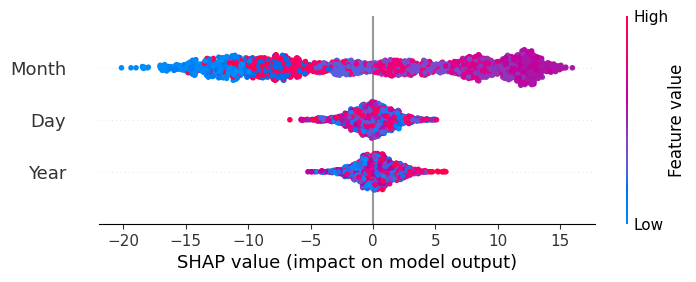

In [539]:
shap.plots.beeswarm(shap_values)

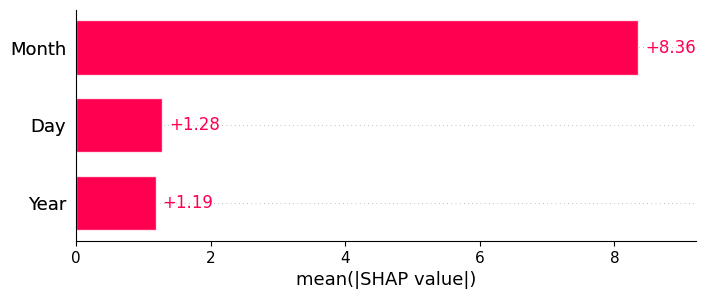

In [540]:
shap.plots.bar(shap_values)

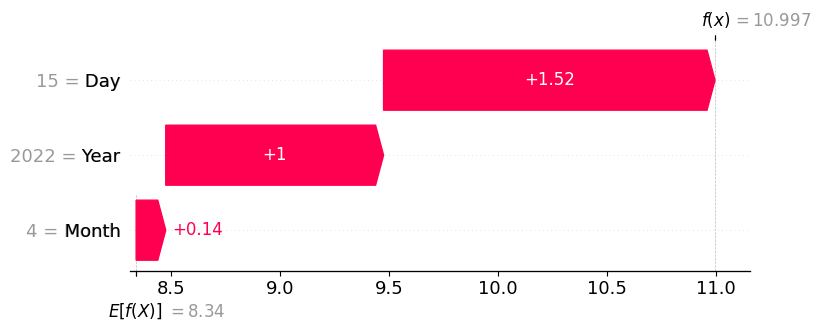

In [541]:
shap.plots.waterfall(shap_values[1200])

In [544]:
def predict_future_temp(year, month, day):
    future_date = pd.DataFrame({"Year": [year], "Month": [month], "Day": [day]})
    future_temp = model.predict(xgb.DMatrix(future_date))
    return future_temp[0]


In [ ]:
predict_future_temp(2025, 12, 13) #it works not amazingly but it works. 
#its predicting the average temp for the day and the average temp gets kind of trolled because it goes down during nighttime which reduces the temp but like no one looks at the temp 
# at night so it kind of skews the tem
#this model overfits like a bitch need way more sample data or use a different model 

-7.2300925

In [419]:
#can try catboost model and compare results

In [558]:
model.save_model("xgboost_regressor_model.json")

In [ ]:
wandb.finish()